### Data Science Capstone: College Scorecard Investigation

Here, I am using the most recent data from the US Department of Education's College Scorecard for the 2021-2022 school year and supplementing it with previous years' data to investigate a number of questions. Find the data sets used here: https://collegescorecard.ed.gov/data 

The questions I'm interested are as follows:
> 1. How does the median debt at graduation vary across different Carnegie classifications of institutions?
> 2. Are there regional trends in graduation rates?
> 3. Does the selectivity of an institution (e.g., acceptance rate and SAT scores) correlate with its graduation rates?
> 4. Do public vs. private vs. for-profit institutions show distinct patterns in costs, debt, or graduation rates?
> 5. What factors drive graduation rates?


To answer these questions, I'll first import the needed libraries, read in the data, and define some functions to clean the data. The cleaning functions do two major tasks: first, a number of attributes that are spread across multiple columns are combined into one column. For example, I will use graduation rate as measured by 150% of time to completion for the average degree program a lot. But the data set divides this metric into one for 4 year institutions and one for less than four year institutions. While there are interesting differences between these metrics, for my purposes, I'm most interested in the overall rate of completion, so I will combine them into one column. To do this, I use the forward fill function on the relevant columns and create a new column for the combined graduation rate metric. 

Second, I replace a common kind of missing data, the 'PrivacySupressed' value, with NaN to make it easier to spot and work with. A school will have 'PrivacySupressed' as a value when there are too few students in a group such that reporting the value might compromise the anonymity of the students in question. This happens a lot for small schools or small subsets of student demographics. However, 'PrivacySupressed' as a value often messes with columns, because it forces numeric columns to be strings. The issue of converting the column type will be dealt with later down the line. 

There isn't a single school that has complete data for the 2021-2022 school year, so I will supplement the data with values pulled from previous years. To do so, I will add a tag for the year and use the combine first function. Combine first preserves every data point in the first DataFrame first, then replaces any NaNs with data from the second DataFrame. Doing this ensures that the most recent data is what's always retained first, while any missing values can be supplemented. The year tag shows the last year for which additional data has to be added to get complete data; this is just to track how frequently the function is being used. 

Combining data across years comes with one possible complication for any data reported as a dollar value; inflation decreases the value of money from year to year, and college tuition infamously rises at a rate faster than inflation. Luckily, the data for median income after graduation, faculty pay, cost of tuition, and debt after finishing are all variables with fairly complete data in the first year of the dataset; at most, about 2,500 schools are missing one or more of these financial metrics, and it's much less for many metrics (the one with the most missing is faculty salaries, which are (unfortunately for the faculty) easily the most stable over time). Using one additional year of data alone reduces the amount of school missing data on, for example, debt after finishing from around 1,600 schools to about 600! While changes in the value of money happen, the effect of inflation isn't so large as to render the data useless, and filling in from previous years is the most reasonable approach to balance the need for additional data with the need for accuracy in data. I also limit the number of years used to fill in missing values to four additional years, again to strike a balance between missing data and accuracy in the data. 

Another potential issue is that the values will fluctuate wildly from year to year. This is always possible, and is especially significant for very small schools; if a school only has cohorts of ten students, the graduation rate may vary by 10% easily! However, there are relatively few schools of that size, and most metrics are likely stable across time to a degree that makes analysis possible, at least. Again, the trade off is between more complete data and perfectly accurate data; my approach allows a reasonable balance of both. 

Ultimately, combining across years gives a much more complete picture of each relevant metric in the data than is captured by just one year's worth. The creators of the College Scoreboard dataset recognize this because they sometimes use pooled metrics across years (such as a two year pooled graduation rate) to smooth out minor fluctuations. Combining across years gives a more complete picture, without making major sacrifices to data quality. 

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor as RFR
from scipy import stats
from sklearn.inspection import PartialDependenceDisplay 
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

%matplotlib inline

In [42]:
df = pd.read_csv("Most-Recent-Cohorts-Institution.csv",low_memory=False)

In [43]:
def ffill_df(old_df):
    """
    Forward fills selected columns from a DataFrame and creates a new columns
    
    Args:
        old_df (pandas.DataFrame): The raw DataFrame with the relevant columns
    
    Returns: 
        pandas.DataFrame: A new DataFrame with a new column with consolidated values for the selected columns
    """
  
    df_c150 = old_df[['C150_4','C150_L4']].copy()
    df_c150.ffill(axis=1,inplace=True)
    old_df['FULL_C150'] = df_c150['C150_L4']

    df_ret = old_df[['RET_FT4','RET_FTL4']].copy()
    df_ret.ffill(axis=1,inplace=True)
    old_df['FULL_RET_FT'] = df_ret['RET_FTL4']

    df_cost = old_df[['COSTT4_A','COSTT4_P']].copy()
    df_cost.ffill(axis=1,inplace=True)
    old_df['FULL_COSTT'] = df_cost['COSTT4_P']
    new_df = old_df.copy()
    return new_df

In [44]:
def clean_data(old_df,year):
    """
    Cleans and preprocesses a DataFrame of college scorecard data.
    
    Args:
        old_df (pandas.DataFrame): The raw DataFrame containing college data.
        year (int): The year to be associated with the data.

    Returns:
        pandas.DataFrame: A new DataFrame with the following modifications:
            - Missing values filled using forward fill on specific columns.
            - 'PrivacySuppressed' values replaced with NaN.
            - 'YEAR' column added.
    """
    ffill_df(old_df)
    old_df = old_df.replace('PrivacySuppressed', np.nan)
    new_df = old_df.copy()
    new_df['YEAR'] = year
    return new_df

In [45]:
df_2021_clean = clean_data(df,2021)



In [46]:
df_2020 = pd.read_csv("MERGED2020_21_PP.csv",low_memory=False)

In [47]:
df_2020 = df_2020[df_2020['UNITID'].isin(df_2021_clean['UNITID'])]
df_2020_clean = clean_data(df_2020,2020)
two_year_df = df_2021_clean.combine_first(df_2020_clean)


In [48]:
df_2019 = pd.read_csv("MERGED2019_20_PP.csv",low_memory=False)

In [49]:
df_2019 = df_2019[df_2019['UNITID'].isin(df_2021_clean['UNITID'])]
df_2019_clean = clean_data(df_2019,2019)
three_year_df = two_year_df.combine_first(df_2019_clean)


In [50]:
df_2018 = pd.read_csv("MERGED2018_19_PP.csv",low_memory=False)
df_2018 = df_2018[df_2018['UNITID'].isin(df_2021_clean['UNITID'])]
df_2018_clean = clean_data(df_2018,2018)
four_year_df = three_year_df.combine_first(df_2018_clean)

In [51]:
df_2017 = pd.read_csv("MERGED2017_18_PP.csv",low_memory=False)
df_2017 = df_2017[df_2017['UNITID'].isin(df_2021_clean['UNITID'])]
df_2017_clean = clean_data(df_2017,2017)
five_year_df = four_year_df.combine_first(df_2017_clean)


In [52]:
five_year_df1 = five_year_df[['UNITID','HIGHDEG','CONTROL','AVGFACSAL','PFTFAC','PCTPELL','MD_EARN_WNE_P10','UGDS','UGDS_MEN','UGDS_WHITE','UGDS_BLACK','UGDS_HISP',
'UGDS_ASIAN','UGDS_AIAN','UGDS_NHPI','UGDS_2MOR','UGDS_NRA','UGDS_UNKN','PCTFLOAN','GRAD_DEBT_MDN','WDRAW_DEBT_MDN','ICLEVEL','STUFACR','FULL_RET_FT','FULL_COSTT',
'FULL_C150', 'YEAR',]].copy()

After cleaning the data and combining data across years, it's time to look into our first question. 

#### How does the median debt at graduation vary across different Carnegie classifications of institutions?
First, let's see what median debt looks like for all schools. There are two categories: debt for those who graduate, and debt for those who leave before graduation (for any reason). Debt for finishers is higher than it is for non-finishers, hopefully for obvious reasons. For non-finishers, the distribution is unimodal and fairly compact, with the mode between $2,500 and $5,000. For graduates, debt is bimodal, one between $7,500 and $10,000 and another between $22,500 and $25,000. But how does it compare at different kinds of institutions? 

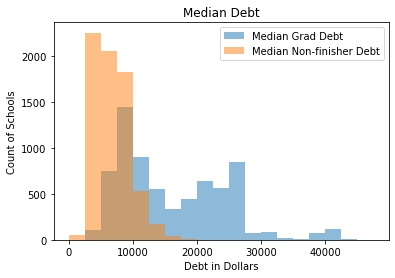

In [53]:
bins = np.arange(0, 50000,2500)
ps_dropped = five_year_df[~((five_year_df['GRAD_DEBT_MDN'] == 'PrivacySuppressed') | (five_year_df['WDRAW_DEBT_MDN'] == 'PrivacySuppressed'))].copy()
ps_dropped['GRAD_DEBT_MDN'] = pd.to_numeric(ps_dropped['GRAD_DEBT_MDN'], errors='coerce')
ps_dropped['WDRAW_DEBT_MDN'] = pd.to_numeric(ps_dropped['WDRAW_DEBT_MDN'], errors='coerce')

plt.hist(data=ps_dropped, x='GRAD_DEBT_MDN', bins=bins, alpha=0.5, label='Median Grad Debt');
plt.hist(data=ps_dropped, x='WDRAW_DEBT_MDN', bins=bins, alpha=0.5, label='Median Non-finisher Debt')
plt.title('Median Debt')
plt.xlabel('Debt in Dollars')
plt.ylabel('Count of Schools')
plt.legend();

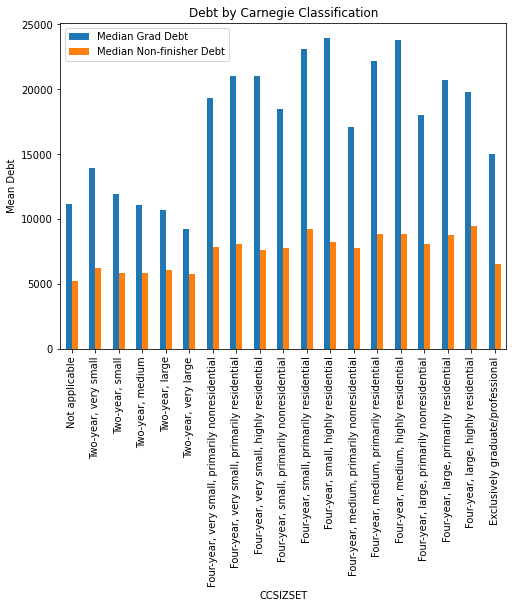

In [54]:
classification_mapping = {
    -2: "Not applicable",
    0: "(Not classified)",
    1: "Two-year, very small",
    2: "Two-year, small",
    3: "Two-year, medium",
    4: "Two-year, large",
    5: "Two-year, very large",
    6: "Four-year, very small, primarily nonresidential",
    7: "Four-year, very small, primarily residential",
    8: "Four-year, very small, highly residential",
    9: "Four-year, small, primarily nonresidential",
    10: "Four-year, small, primarily residential",
    11: "Four-year, small, highly residential",
    12: "Four-year, medium, primarily nonresidential",
    13: "Four-year, medium, primarily residential",
    14: "Four-year, medium, highly residential",
    15: "Four-year, large, primarily nonresidential",
    16: "Four-year, large, primarily residential",
    17: "Four-year, large, highly residential",
    18: "Exclusively graduate/professional"
}

grad_mean = ps_dropped.groupby(['CCSIZSET'])['GRAD_DEBT_MDN'].mean() 
wdraw_mean = ps_dropped.groupby(['CCSIZSET'])['WDRAW_DEBT_MDN'].mean()
grouped_df = pd.DataFrame({"Median Grad Debt": grad_mean, 'Median Non-finisher Debt': wdraw_mean})
ax = grouped_df.plot.bar(figsize=(8, 6), title="Debt by Carnegie Classification",
                         xlabel="CCSIZSET", ylabel="Mean Debt", rot=90)

grouped_ccs = grouped_df.index.tolist()
relevant_labels = [classification_mapping[code] for code in grouped_ccs if code in classification_mapping]

ax.legend(loc='best')
ax.set_xticklabels(relevant_labels)
plt.show()

Graduates at four year institutions of all sizes generally have higher debt than those at two year institutions. Residential schools also have higher rates of median debt. The overall cost of a four year, residential program will be consistently higher than that of a two year, non-residential program. Ther average debt for non-finishers, however, is much more similar for all institution types, clustered just above $5000. One surprise: grad only institutions have lower median debt than most four year institutions, despite the fact that grad school is often expensive and paid for with loans.

#### Are there regional trends in graduation rates?

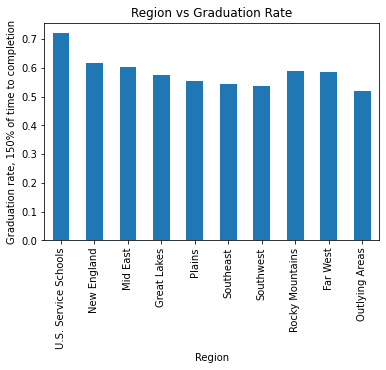

In [56]:
region_mapping = {
    0: "U.S. Service Schools",
    1: "New England",
    2: "Mid East",
    3: "Great Lakes",
    4: "Plains",
    5: "Southeast",
    6: "Southwest",
    7: "Rocky Mountains",
    8: "Far West",
    9: "Outlying Areas"
}

ax = grouped_df.plot.bar(title = 'Region vs Graduation Rate',xlabel = 'Region',ylabel = 'Graduation rate, 150% of time to completion')
grouped_df = five_year_df.groupby(['REGION'])['FULL_C150'].mean()
grouped_regions = grouped_df.index.tolist()
relevant_labels = [region_mapping[region_code] for region_code in grouped_regions]
ax.set_xticklabels(relevant_labels)
plt.show();

The most notable trend is that the service academies have much higher rates of graduation than any other region; this is likely due to their relatively small number and high selectivity. But New England has the highest average graduation rate, despite having a disproportionate number of its colleges, and outlying areas (including mostly schools in US territories) have the lowest. 


#### Does the selectivity of an institution (e.g., average SAT score or acceptance rate) correlate with its graduation rates?

First, let's look at SAT average. 

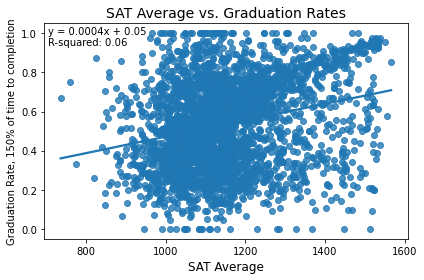

In [57]:
df_subset = five_year_df[['SAT_AVG', 'FULL_C150']]
df_subset_dropna = df_subset.dropna(subset=['SAT_AVG', 'FULL_C150'])

slope, intercept, r_value, _, _ = stats.linregress(
    df_subset_dropna['SAT_AVG'], df_subset_dropna['FULL_C150'])

ax = sns.regplot(data=five_year_df, x='SAT_AVG', y='FULL_C150', ci=None)
ax.set_title('SAT Average vs. Graduation Rates', fontsize=14)
ax.set_xlabel('SAT Average', fontsize=12)
ax.set_ylabel('Graduation Rate, 150% of time to completion', fontsize=10)  

ax.text(0.01, 0.95, f"y = {slope:.4f}x + {intercept:.2f}", transform=ax.transAxes)
ax.text(0.01, 0.9, f"R-squared: {r_value**2:.2f}", transform=ax.transAxes)

plt.tight_layout()
plt.show();

While there is a slight overall positive trend, the r-squared shows that the relationship between SAT averages and graduation rates is not a strong one. Let's look at the graduation rate just at four year institutions, where SAT scores are generally more frequently used. 

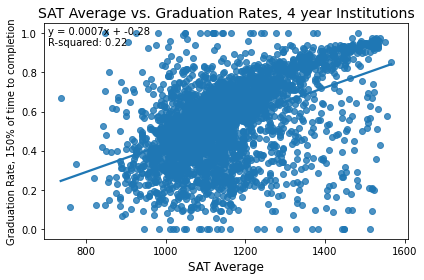

In [58]:
df_subset = five_year_df[['SAT_AVG', 'C150_4']]  
df_subset_dropna = df_subset.dropna(subset=['SAT_AVG', 'C150_4'])  

slope, intercept, r_value, _, _ = stats.linregress(
    df_subset_dropna['SAT_AVG'], df_subset_dropna['C150_4']
)

ax = sns.regplot(data=five_year_df, x='SAT_AVG', y='C150_4', ci=None)  
ax.set_title('SAT Average vs. Graduation Rates, 4 year Institutions', fontsize=14)
ax.set_xlabel('SAT Average', fontsize=12)
ax.set_ylabel('Graduation Rate, 150% of time to completion', fontsize=10)  

ax.text(0.01, 0.95, f"y = {slope:.4f}x + {intercept:.2f}", transform=ax.transAxes)
ax.text(0.01, 0.9, f"R-squared: {r_value**2:.2f}", transform=ax.transAxes)

plt.tight_layout()
plt.show()

The strength of the relationship increases, but it is still not a strong relationship, although the general trend is that higher average SAT scores correspond to higher graduation rates. 

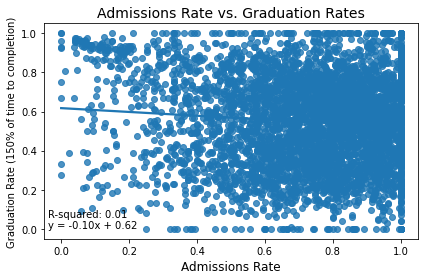

In [59]:
df_subset = five_year_df[['ADM_RATE', 'FULL_C150']]
df_subset_dropna = df_subset.dropna(subset=['ADM_RATE', 'FULL_C150'])

slope, intercept, r_value, _, _ = stats.linregress(
    df_subset_dropna['ADM_RATE'], df_subset_dropna['FULL_C150'])

ax = sns.regplot(data=five_year_df, x='ADM_RATE', y='FULL_C150', ci=None)
ax.set_title('Admissions Rate vs. Graduation Rates', fontsize=14)
ax.set_xlabel('Admissions Rate', fontsize=12)
ax.set_ylabel('Graduation Rate (150% of time to completion)', fontsize=10)

ax.text(0.01, 0.05, f"y = {slope:.2f}x + {intercept:.2f}", transform=ax.transAxes)
ax.text(0.01, 0.1, f"R-squared: {r_value**2:.2f}", transform=ax.transAxes)

plt.tight_layout()
plt.show()

Admissions rate has less predictive power than SAT average does on graduation rate. Both of these findings are rather surprising! It makes sense that more selective schools would have higher graduation rates, because they select the top students from their applicant pools. The ETS also claims that the SAT is predictive of college success but that doesn't seem to be necessarily true. 

#### Do public vs. private vs. for-profit institutions show distinct patterns in costs, debt, or graduation rates?
First, we'll focus on the relevant columns, then remove any irrelavant rows and ensure all the needed columns are numeric. Then we can make some violin plots that shows the distribution of a number of variables of interest.  

In [60]:
df_select = five_year_df[['SAT_AVG','ADM_RATE','CONTROL',"FULL_C150",'MD_EARN_WNE_P10','FULL_COSTT','PCTPELL','PCTFLOAN','GRAD_DEBT_MDN','WDRAW_DEBT_MDN']].copy()
control_mapping = {1: 'Public', 2: 'Private nonprofit', 3: 'Private for profit'}
df_select['CONTROL'] = df_select['CONTROL'].map(control_mapping)
classes = ['Public','Private nonprofit', 'Private for profit']
typeclasses = pd.CategoricalDtype(ordered=True, categories=classes)
df_select['CONTROL'] = df_select['CONTROL'].astype(typeclasses);

ps_dropped_select = df_select[~((df_select['GRAD_DEBT_MDN'] == 'PrivacySuppressed') | (df_select['WDRAW_DEBT_MDN'] == 'PrivacySuppressed'))].copy()
ps_dropped_select['GRAD_DEBT_MDN'] = pd.to_numeric(ps_dropped_select['GRAD_DEBT_MDN'], errors='coerce')
ps_dropped_select['WDRAW_DEBT_MDN'] = pd.to_numeric(ps_dropped_select['WDRAW_DEBT_MDN'], errors='coerce')

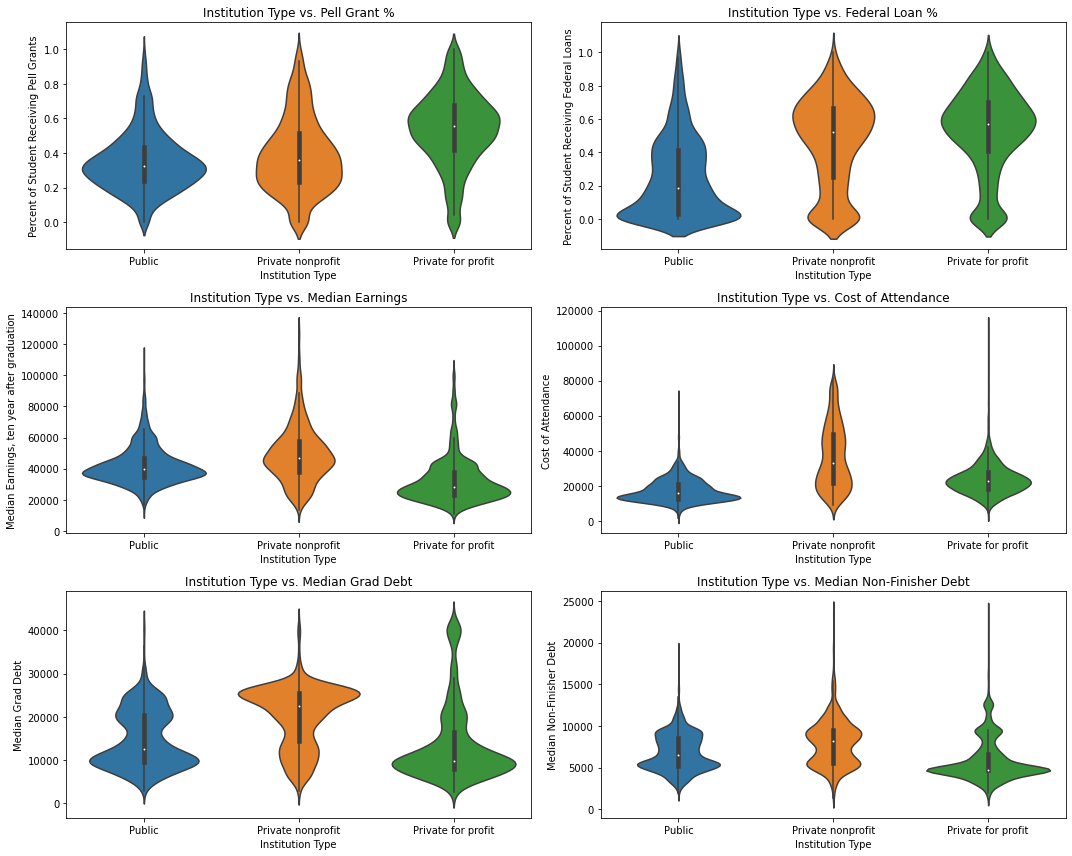

In [61]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))  

sns.violinplot(ax=axes[0, 0], data=df_select, x='CONTROL', y='PCTPELL')
axes[0, 0].set_title('Institution Type vs. Pell Grant %')
axes[0, 0].set_xlabel('Institution Type')
axes[0, 0].set_ylabel('Percent of Student Receiving Pell Grants')

sns.violinplot(ax=axes[0, 1], data=df_select, x='CONTROL', y='PCTFLOAN')
axes[0, 1].set_title('Institution Type vs. Federal Loan %')
axes[0, 1].set_xlabel('Institution Type')
axes[0, 1].set_ylabel('Percent of Student Receiving Federal Loans')

sns.violinplot(ax=axes[1, 0], data=df_select, x='CONTROL', y='MD_EARN_WNE_P10')
axes[1, 0].set_title('Institution Type vs. Median Earnings')
axes[1, 0].set_xlabel('Institution Type')
axes[1, 0].set_ylabel('Median Earnings, ten year after graduation')

sns.violinplot(ax=axes[1, 1], data=df_select, x='CONTROL', y='FULL_COSTT')
axes[1, 1].set_title('Institution Type vs. Cost of Attendance')
axes[1, 1].set_xlabel('Institution Type')
axes[1, 1].set_ylabel('Cost of Attendance')

sns.violinplot(ax=axes[2, 0],data=ps_dropped_select, x='CONTROL', y='GRAD_DEBT_MDN')
axes[2, 0].set_title('Institution Type vs. Median Grad Debt')
axes[2, 0].set_xlabel('Institution Type')
axes[2, 0].set_ylabel('Median Grad Debt')

sns.violinplot(ax=axes[2, 1],data=ps_dropped_select, x='CONTROL', y='WDRAW_DEBT_MDN')
axes[2, 1].set_title('Institution Type vs. Median Non-Finisher Debt')
axes[2, 1].set_xlabel('Institution Type')
axes[2, 1].set_ylabel('Median Non-Finisher Debt')


plt.tight_layout()
plt.show()

Pell grants are more common at private for profit institutions, as are federal loans; private nonprofits also have substantial number of students using private loans, although students at public schools are less likely to use either federal loans or Pell grants.

Public and nonprofit private institutions have similar distributions of median incomes after ten years, while for profit private institutions have lower median future wages. There are private institutions at almost every price point, but public ones are generally the least expensive. 

Students at private nonprofit institutions generally have a higher debt burden than those at the other two types. Median debt for non-finishers is more similar across all three institution types, with two concentrations around $5000 and $10000. 



#### What factors drive graduation rates?
To answer this question, I will build a random forest model. To do so, I'll first make a new DataFrame with only the relevant columns. Next, I'll map the categorical variables to their labels. Finally, I'll create dummy variables for each categorical variable. 

I selected the variables that I think are most likely to impact graduation rates: demographics of the student population by race, type of school, earnings after graduation, median debt for finishers and non finishers, retention rates, cost of tuition, percent of students using Pell grants and federal loans, faculty salaries, faculty to student ratios, and percent full time faculty. 

In [62]:
five_year_df

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,OMAWDP8_NOPELL_NOTFIRSTTIME,OMENRUP_NOPELL_NOTFIRSTTIME,OMACHT8_NOPELL_ALL,OMACHT8_NOPELL_FIRSTTIME,OMACHT8_NOPELL_NOTFIRSTTIME,ADDR,FULL_C150,FULL_RET_FT,FULL_COSTT,YEAR
0,100654,100200.0,1002.0,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,www.aamu.edu/admissions-aid/tuition-fees/net-p...,...,0.4744,0.2179,329.0,251.0,78.0,4900 Meridian Street,0.2807,0.5797,21924.0,2021
1,100663,105200.0,1052.0,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,https://www.uab.edu/,https://tcc.ruffalonl.com/University of Alabam...,...,0.5136,0.2117,2358.0,1182.0,1176.0,Administration Bldg Suite 1070,0.6245,0.8392,26248.0,2021
2,100690,2503400.0,25034.0,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,https://www.amridgeuniversity.edu/,https://www2.amridgeuniversity.edu:9091/,...,0.4583,0.2083,26.0,2.0,24.0,1200 Taylor Rd,0.4444,0.5000,20100.0,2021
3,100706,105500.0,1055.0,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu/,finaid.uah.edu/,...,0.5948,0.1324,1122.0,510.0,612.0,301 Sparkman Dr,0.6072,0.7899,24869.0,2021
4,100724,100500.0,1005.0,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu/,www.alasu.edu/cost-aid/tuition-costs/net-price...,...,0.3667,0.4889,510.0,420.0,90.0,915 S Jackson Street,0.2843,0.6436,21938.0,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7100,48092101,4220001.0,42200.0,Designer Barber & Stylist School -,Fort Smith,AR,72903-3701,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017
7101,48133101,4213501.0,42135.0,Sharp Edgez Barber Institute - Buffalo,Buffalo,NY,14217-0000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017
7108,48387801,4223701.0,42237.0,Bay Area Medical Academy - San Jose Satellite ...,San Jose,CA,95113,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017
7109,48400201,4228101.0,42281.0,High Desert Medical College - Bakerfield,Bakersfield,CA,93301,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017


In [63]:
five_year_df_clean = five_year_df[['AVGFACSAL','FULL_C150','FULL_COSTT', 'FULL_RET_FT', 'GRAD_DEBT_MDN', 'MD_EARN_WNE_P10', 'PCTFLOAN', 'PCTPELL', 'PFTFAC', 'STUFACR', 'UGDS', 'UGDS_2MOR', 'UGDS_AIAN', 'UGDS_ASIAN', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_MEN', 'UGDS_NHPI', 'UGDS_NRA', 'UGDS_UNKN', 'UGDS_WHITE', 'WDRAW_DEBT_MDN','CONTROL', "ICLEVEL",'HIGHDEG']].copy()

In [64]:
control_mapping = {1: 'Public', 2: 'Private nonprofit', 3: 'Private for profit'}
five_year_df_clean['CONTROL'] = five_year_df_clean['CONTROL'].map(control_mapping)

level_mapping = {1: "4-year", 2:"2-year", 3: "Less-than-2-year"}
five_year_df_clean['ICLEVEL'] = five_year_df_clean['ICLEVEL'].map(level_mapping)

high_deg_mapping = {0:"Non-degree-granting", 1:"Certificate degree", 2:"Associate degree", 3:"Bachelor's degree", 4:"Graduate degree"}
five_year_df_clean['HIGHDEG'] = five_year_df_clean['HIGHDEG'].map(high_deg_mapping)



In [65]:
five_year_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7006 entries, 0 to 7111
Data columns (total 25 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AVGFACSAL        6009 non-null   float64
 1   FULL_C150        6422 non-null   float64
 2   FULL_COSTT       6531 non-null   float64
 3   FULL_RET_FT      6510 non-null   float64
 4   GRAD_DEBT_MDN    6949 non-null   object 
 5   MD_EARN_WNE_P10  6356 non-null   float64
 6   PCTFLOAN         6591 non-null   float64
 7   PCTPELL          6591 non-null   float64
 8   PFTFAC           5654 non-null   float64
 9   STUFACR          6595 non-null   float64
 10  UGDS             6596 non-null   float64
 11  UGDS_2MOR        6596 non-null   float64
 12  UGDS_AIAN        6596 non-null   float64
 13  UGDS_ASIAN       6596 non-null   float64
 14  UGDS_BLACK       6596 non-null   float64
 15  UGDS_HISP        6596 non-null   float64
 16  UGDS_MEN         6596 non-null   float64
 17  UGDS_NHPI     

In [66]:
clean_df = pd.get_dummies(five_year_df_clean, columns=['CONTROL','ICLEVEL','HIGHDEG'])


In [67]:
clean_df['GRAD_DEBT_MDN'] = clean_df['GRAD_DEBT_MDN'].astype(np.float64)
clean_df['WDRAW_DEBT_MDN'] = clean_df['WDRAW_DEBT_MDN'].astype(np.float64)

In [68]:
clean_df.head()

,AVGFACSAL,FULL_C150,FULL_COSTT,FULL_RET_FT,GRAD_DEBT_MDN,MD_EARN_WNE_P10,PCTFLOAN,PCTPELL,PFTFAC,STUFACR,...,CONTROL_Private nonprofit,CONTROL_Public,ICLEVEL_2-year,ICLEVEL_4-year,ICLEVEL_Less-than-2-year,HIGHDEG_Associate degree,HIGHDEG_Bachelor's degree,HIGHDEG_Certificate degree,HIGHDEG_Graduate degree,HIGHDEG_Non-degree-granting
0,8779.0,0.2807,21924.0,0.5797,31000.0,39059.0,0.6552,0.6853,0.6833,18.0,...,0,1,0,1,0,0,0,0,1,0
1,11590.0,0.6245,26248.0,0.8392,22300.0,50907.0,0.4401,0.3253,0.7564,19.0,...,0,1,0,1,0,0,0,0,1,0
2,4672.0,0.4444,20100.0,0.5000,32189.0,37730.0,0.8423,0.7852,0.7872,13.0,...,1,0,0,1,0,0,0,0,1,0
3,9820.0,0.6072,24869.0,0.7899,20705.0,56901.0,0.3578,0.2377,0.6538,19.0,...,0,1,0,1,0,0,0,0,1,0
4,7701.0,0.2843,21938.0,0.6436,31000.0,34018.0,0.7637,0.7205,0.6812,13.0,...,0,1,0,1,0,0,0,0,1,0


In [69]:
null_rows = clean_df[clean_df.isnull().any(axis=1)]

clean_df_nulls = pd.DataFrame(null_rows)
clean_df.dropna(inplace=True)

I dropped all the rows with missing values, leaving me with 5,355 schools to analyze out of 7,000. I split my DataFrame into one with all my variables and one with just my outcome. 

In [70]:
X = clean_df[['AVGFACSAL','FULL_COSTT', 'FULL_RET_FT', 'GRAD_DEBT_MDN', 'MD_EARN_WNE_P10', 'PCTFLOAN', 'PCTPELL', 'PFTFAC', 'STUFACR', 'UGDS', 'UGDS_2MOR', 'UGDS_AIAN', 'UGDS_ASIAN', 'UGDS_BLACK', 'UGDS_HISP', 'UGDS_MEN', 'UGDS_NHPI', 'UGDS_NRA', 'UGDS_UNKN', 'UGDS_WHITE', 'WDRAW_DEBT_MDN', 'CONTROL_Private for profit', 'CONTROL_Private nonprofit', 'CONTROL_Public', 'ICLEVEL_2-year', 'ICLEVEL_4-year', 'ICLEVEL_Less-than-2-year', 'HIGHDEG_Associate degree', "HIGHDEG_Bachelor's degree", 'HIGHDEG_Certificate degree', 'HIGHDEG_Graduate degree', 'HIGHDEG_Non-degree-granting']].copy()
y = clean_df["FULL_C150"].copy()

In [71]:
clf=RFR(n_estimators=200,max_depth=20,random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
clf.fit(X_train,y_train)
y_prediction=clf.predict(X_test)
rsquared_score = r2_score(y_test, y_prediction)
length_y_test = len(y_test)

print("The r-squared score for your model was {} on {} values.".format(rsquared_score, length_y_test))

MSE_score = mean_squared_error(y_test, y_prediction)
print("The mean squared error score for your model was {} on {} values.".format(MSE_score, length_y_test))

The r-squared score for your model was 0.521264662458044 on 1607 values.
The mean squared error score for your model was 0.025352346439646425 on 1607 values.


The model can predict 52% of the variance in the graduation rates for the test values. 


In [78]:
param_grid = {
    'rfr__n_estimators': [100, 200, 300],  
    'rfr__max_depth': [None, 10, 20, 30],    
    'rfr__min_samples_split': [2, 5, 10],   
    'rfr__min_samples_leaf': [1, 2, 4]       
}

# Create the pipeline
pipeline = Pipeline([
      ('rfr', RFR(random_state=42))  
])

# Initialize GridSearchCV with 'r2' scoring
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')

# Fit the pipeline and tune hyperparameters
grid_search.fit(X_train, y_train) 

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate on the test set
y_pred = best_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"R-squared on Test Set: {r2:.4f}")
print(f"Mean Squared Error on Test Set: {mse:.4f}")

Best Hyperparameters: {'rfr__max_depth': None, 'rfr__min_samples_leaf': 4, 'rfr__min_samples_split': 2, 'rfr__n_estimators': 300}
R-squared on Test Set: 0.5232
Mean Squared Error on Test Set: 0.0253


Next I want to know what variables are most important to my model, similar to the coefficient weights from a linear model. However, it is less straightforward for RFR. I need to systematically drop each predictor and compare the r-squared it returns; if dropping the variable lowers r-squared, the variable is an important predictor and if there's little change, it's less important as a predictor. 

In [80]:
def compare_feature_drops(X, y, max_depth = None, min_samples_leaf = 4, min_samples_split = 2, n_estimators=300, random_state=42):
    """
    Calculates the difference in R-squared when dropping features compared to a full Random Forest model.

    Args:
        X (pd.DataFrame): Input features.
        y (pd.Series): Target variable.
        n_estimators (int, optional): Number of trees in the Random Forest. Defaults to 200.
        max_depth (int, optional): Maximum depth of the trees. Defaults to 20.
        random_state (int, optional): Random seed for reproducibility. Defaults to 42.

    Returns:
        pd.DataFrame: DataFrame containing dropped column names and R-squared differences.
    """

    results = []

    # Fit a base full model
    full_model = RFR(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)
    full_model.fit(X_train, y_train)
    y_pred = full_model.predict(X_test)
    base_rsquared = r2_score(y_test, y_pred) 

    for column in X:
        X_dropped = X.drop(column, axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X_dropped, y, test_size=0.30, random_state=random_state)

        clf = RFR(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        rsquared = r2_score(y_test, y_pred)

        results.append({'Column': column, 'R-Squared Difference': base_rsquared - rsquared})

    return pd.DataFrame(results)


results_df = compare_feature_drops(X, y)


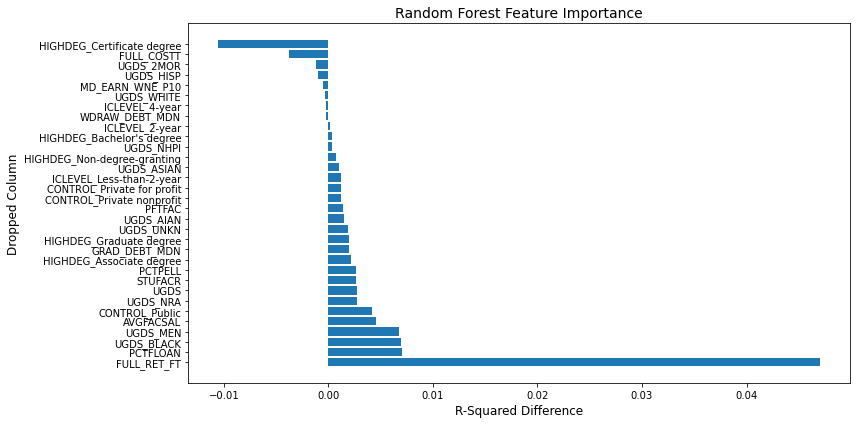

In [81]:
results_df = results_df.sort_values('R-Squared Difference', ascending=False) 
plt.figure(figsize=(12, 6)) 

plt.barh(results_df['Column'], results_df['R-Squared Difference']) 
plt.ylabel('Dropped Column') 
plt.xlabel('R-Squared Difference') 
plt.title('Random Forest Feature Importance')
plt.xlabel('R-Squared Difference', fontsize=12)
plt.ylabel('Dropped Column', fontsize=12)
plt.title('Random Forest Feature Importance', fontsize=14)

plt.tight_layout()
plt.show()

Retention rate is far and away the most significant factor; dropping it from the model worsens the model performance more than any other predictor. There is also a built-in measure of importance that measures the impact of shuffling the values for a particular predictor; if shuffling values changes the predictive power of the model, then the feature is important. 

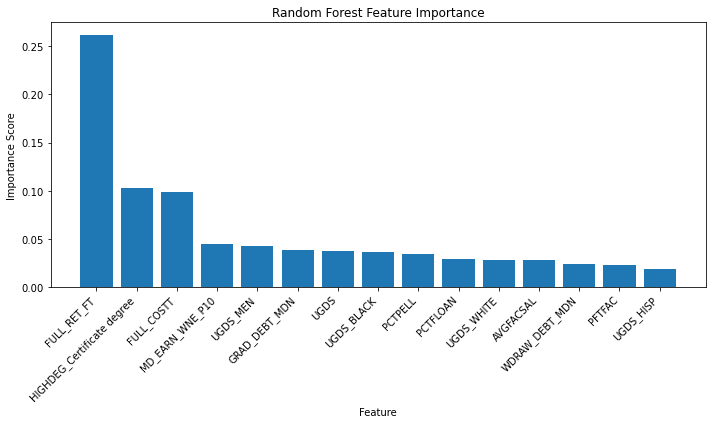

In [82]:
clf = RFR(n_estimators=200, max_depth=20, random_state=42)
clf.fit(X_train, y_train)

# Get feature importances
importances = clf.feature_importances_
feature_importances = sorted(zip(importances, X.columns), reverse=True)
feature_names = [name for _, name in feature_importances]
importances = [score for score, _ in feature_importances]

# Top N features 
n_features = 15
feature_names = feature_names[:n_features]
importances = importances[:n_features]

# Create bar chart
plt.figure(figsize=(10, 6)) 
plt.bar(feature_names, importances)
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Random Forest Feature Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

This version of feature importance also picks out retention rates as the most important predictor. Let's look more closely at the relationship using a partial dependence plot. This plot can identify the relationship between one predictor and the outcome when all other predictors are held constant. 

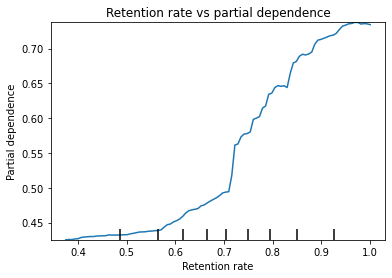

In [83]:
PartialDependenceDisplay.from_estimator(clf, X, [2])
plt.xlabel('Retention rate')
plt.title('Retention rate vs partial dependence');

The relationship looks like a series of small, nearly linear segments with different rates of change. Increases in retention rates between .7 and .8 lead to the fastest increases in graduation rate before leveling off. 